<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_Unipolar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Pulse Width Modulation - Unipolar</h1></b>

Dr. Bingsen Wang

11/24/2023
</center>

#Python Code
The Python code illustrates the unipolar PWM in the context of H-bridge.  There are two mudulation functions and single carrier. For illustration purpose, the same carrier is plotted on two different axes.

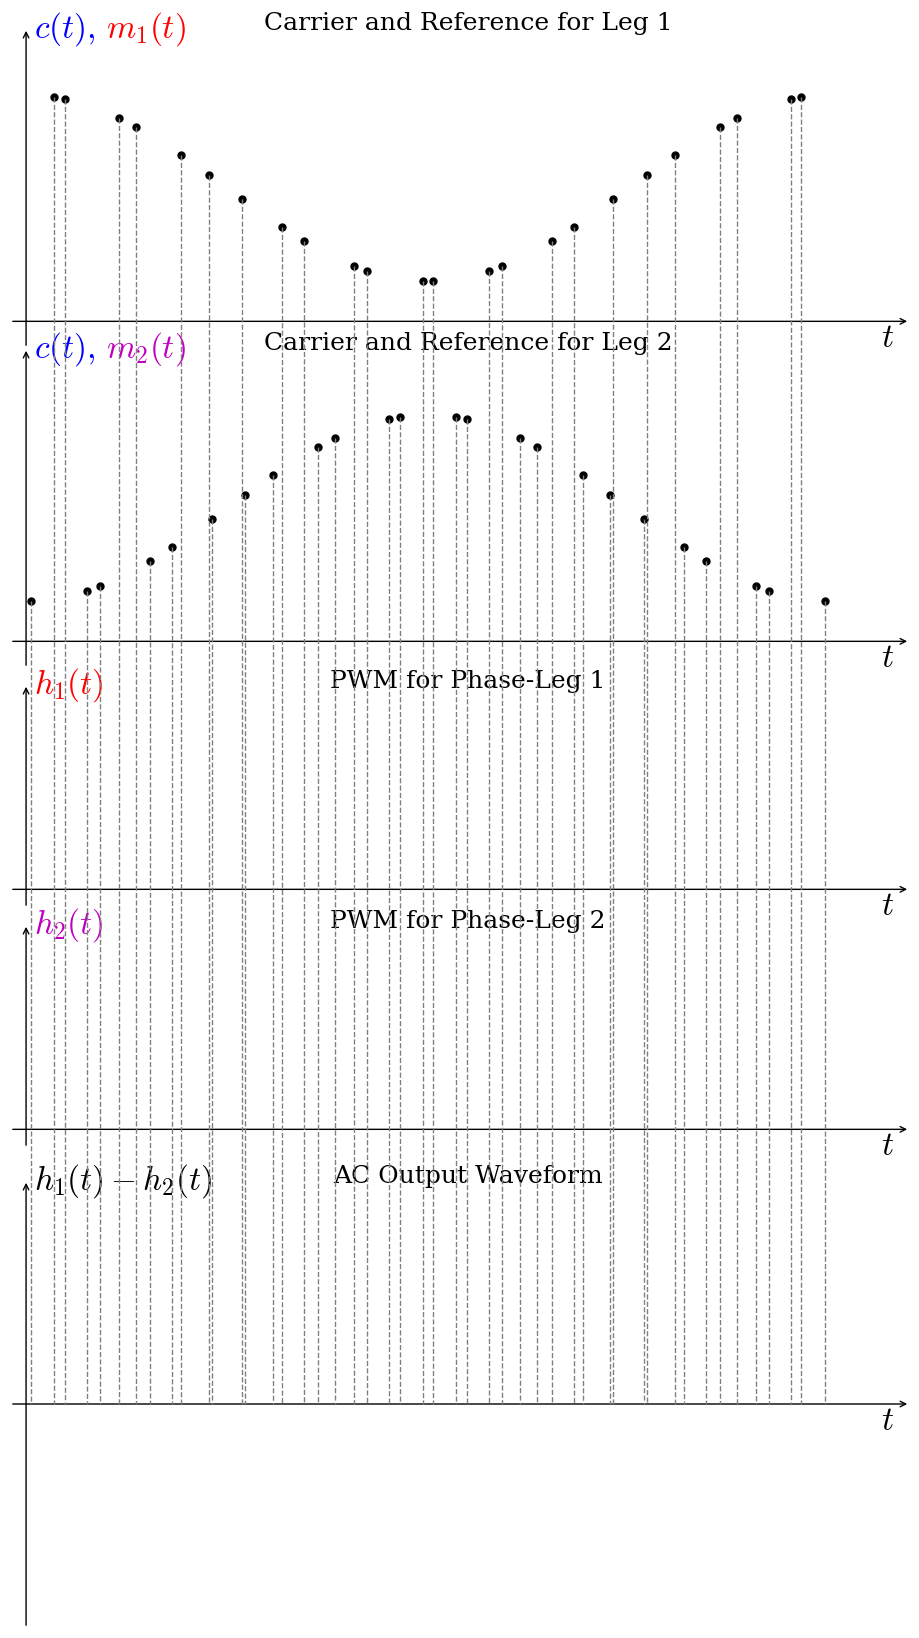

In [16]:
import matplotlib
from os import linesep
from numpy import linspace,cos,pi,sin,random,arccos,heaviside,array
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def carr(f,t): #carrier
  return 1/pi*arccos(cos(2*pi*f*t))

def m(MI,f,theta,t): #modulation function
  return (MI*cos(2*pi*f*t + theta) + 1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

# define the function to be solved
def y(x,*data):
  MI,fm,theta,fc = data
  return m(MI,fm,theta,x) -carr(fc,x)

#solving for intersection points
def intersectionPoints(MI,fm,theta,fc):
  ts=[] #list for intersection points
  for k in range(fc):
    ts.append(fsolve(y,1/fc*(0.25+k),args=(MI,fm,theta,fc))[0])
    ts.append(fsolve(y,1/fc*(0.75+k),args=(MI,fm,theta,fc))[0])
  ts=array(ts)
  mts = m(MI,fm,theta,ts) # m(t) values at intersection points
  return ts,mts

# draw dotted line between two points in two different plots
def l2Ax(fig,ax1,ax2,p1,p2):
  transFigure = fig.transFigure.inverted()
  p1_g = transFigure.transform(ax1.transData.transform(p1))
  p2_g = transFigure.transform(ax2.transData.transform(p2))
  line = matplotlib.lines.Line2D((p1_g[0],p2_g[0]),(p1_g[1],p2_g[1]),
                      transform=fig.transFigure,ls='--',color='gray', lw=1)
  fig.lines.append(line)
  return

#parameters
Nf = 2000 # number of frames
fc = 12 # carrier frequency
fm = 1 # signal
MI = 0.7 # modulation index
theta = 0

#time series
t=linspace(0,1,Nf)
ct = carr(fc,t) #carrier time-domain signal
mt1 = m(MI,fm,0,t) #modulation function time series for leg1
mt2 = m(MI,fm,pi,t) #modulation function time series for leg2
ht1 = h(ct,mt1) #pwm signal time series for leg1
ht2 = h(ct,mt2) #pwm signal time series for leg2

#intersection points
ts1,mts1 = intersectionPoints(MI,fm,0,fc) #leg 1
ts2,mts2 = intersectionPoints(MI,fm,pi,fc) #leg 2

#set up figures
fig = plt.figure(figsize=(9,16))
fig.tight_layout()
ax_frame = [[[0, .8, 1, .2], [-.02,1.1], [-.1, 1.1]], #sine1 & triangle
            [[0, .6, 1, .2], [-.02,1.1], [-.1, 1.1]], #sine2 & triangle
            [[0, .45, 1, .14], [-.02,1.1], [-.1, 1.1]], # pwm - leg1
            [[0, .3, 1, .14], [-.02,1.1], [-.1, 1.1]], # pwm - leg2
            [[0, 0,  1, .28], [-.02,1.1], [-1.1,1.1]], # ac output
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[[['$c(t),$','$m_1(t)$'], '$t$'],
        [['$c(t),$','$m_2(t)$'], '$t$'],
        [r'$h_1(t)$', '$t$'],
        [r'$h_2(t)$', '$t$'],
        [r'$h_1(t)-h_2(t)$', '$t$'],
        ] #yx axes labels
title_lst = ['Carrier and Reference for Leg 1',
             'Carrier and Reference for Leg 2',
             'PWM for Phase-Leg 1',
             'PWM for Phase-Leg 2',
             'AC Output Waveform']
clst=[['b','r'], ['b','m'], 'r','m','k'] #colors of lines
ax_lst=[] #axis list or the list of subplots
lines = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  if k<=1:
    lines.append(ax.plot([], [], clst[k][0], lw=1)[0]) #triangle carrier
    lines.append(ax.plot([], [], clst[k][1], lw=2)[0]) #sine reference
    lines.append(ax.plot([], [], color='k', ls='',marker='o',markersize=5)[0]) #intersection points
    y_text=ax.text(0.01,ym,ax_lbl[k][0][0],size=24,va='center',color=clst[k][0]) #y label
    y_text=ax.text(0.1, ym,ax_lbl[k][0][1],size=24,va='center',color=clst[k][1]) # addtional ylabel
  else:
    lines.append(ax.plot([], [], clst[k], lw=1.5)[0]) #pwm
    y_text=ax.text(0.01,ym,ax_lbl[k][0],size=24,va='center',color=clst[k]) #y label
  ax.text(xm-.02,0,ax_lbl[k][-1],size=24,va='top',ha='right') #x-axis label
  ax.text(0.55,ax_frame[k][2][1]+0.02,title_lst[k],va='center',ha='center',size=18)

# for k in range(len(ts)):
#   l2Ax(fig,ax_lst[0],ax_lst[3],[ts[k],mts[k]],[ts[k],1])
# animation function. This is called sequentially
def animate(i):
  k = int(t[i]*fc) # the kth carrier period
  if k==fc:
    return
  #dot and lines for leg1
  if (t[i] - ts1[2*k]>=0) and (t[i-1] - ts1[2*k]<=0):
    l2Ax(fig,ax_lst[0],ax_lst[4],[ts1[2*k],mts1[2*k]],[ts1[2*k],0])
    lines[2].set_data(ts1[:2*k+1], mts1[:2*k+1])
  if (t[i] - ts1[2*k+1]>=0) and (t[i-1] - ts1[2*k+1]<=0):
    l2Ax(fig,ax_lst[0],ax_lst[4],[ts1[2*k+1],mts1[2*k+1]],[ts1[2*k+1],0])
    lines[2].set_data(ts1[:2*k+2], mts1[:2*k+2]) #intersetion points

  #dot and lines for leg2
  if (t[i] - ts2[2*k]>=0) and (t[i-1] - ts2[2*k]<=0):
    l2Ax(fig,ax_lst[1],ax_lst[4],[ts2[2*k],mts2[2*k]],[ts2[2*k],0])
    lines[5].set_data(ts2[:2*k+1], mts2[:2*k+1])
  if (t[i] - ts2[2*k+1]>=0) and (t[i-1] - ts2[2*k+1]<=0):
    l2Ax(fig,ax_lst[1],ax_lst[4],[ts2[2*k+1],mts2[2*k+1]],[ts2[2*k+1],0])
    lines[5].set_data(ts2[:2*k+2], mts2[:2*k+2]) #intersetion points

  lines[0].set_data(t[:i+1],ct[:i+1])
  lines[1].set_data(t[:i+1],mt1[:i+1])
  lines[3].set_data(t[:i+1],ct[:i+1])
  lines[4].set_data(t[:i+1],mt2[:i+1])
  lines[6].set_data(t[:i+1],ht1[:i+1]) #leg1
  lines[7].set_data(t[:i+1],ht2[:i+1]) #leg2
  lines[8].set_data(t[:i+1],ht1[:i+1]-ht2[:i+1]) #ac output
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"PWM_unipolar.mp4"
writervideo = animation.FFMpegWriter(fps=80)
anim.save(fn, writer=writervideo,dpi = 120)